In [ ]:
#!apt-get install net-tools # To see my interface
!apt-get install tcpdump # To capture packages
#!apt-get install dnsutils
!apt-get install curl # To create traffic to websites
!apt-get install tshark #

In [2]:
!pip install pyshark
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00


In [20]:
import pyshark
import os
import pandas as pd
import nest_asyncio
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/NMDA/HW2"

Mounted at /content/drive


In [4]:
! mkdir captures

In [42]:
! rm captures/*
! rm data/*
! rm *.zip
! rm *.csv

In [43]:
import urllib
import json
def get_information(ip):
        info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
        country = info['country']
        city = info['city']
        latitude = info['lat']
        longitude = info['lon']
        return country, city, latitude, longitude

api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
my_country, my_city, my_latitude, my_longitude =  get_information(my_ip)
my_ip, my_country, my_city, my_latitude, my_longitude

('34.106.175.237', 'United States', 'Salt Lake City', 40.7607, -111.891)

In [44]:
! bash capture.sh captures capture \
    https://www.indiatimes.com \
    https://www.washingtonpost.com \
    https://www.ndtv.com \
    https://www.cnbc.com \
    https://www.timesofindia.com \
    https://www.express.co.uk \
    https://www.rt.com \
    https://www.news18.com \
    https://www.nypost.com \
    https://www.abc.net.au


tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
tcpdump: listening on eth0, link-type EN10MB (Ethernet), snapshot length 262144 bytes
1844 packets captured3725 packets captured

1844 packets received by filter3725 packets received by filter

0 packets dropped by kernel0 pac

In [45]:
import zipfile
directory_to_zip = "/content/captures"
zip_file_name = "captures.zip"

# Create a zipfile object in write mode
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Iterate over all the files and folders within the directory
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            # Construct the full path of the file
            file_path = os.path.join(root, file)
            # Add the file to the zip
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

In [46]:
nest_asyncio.apply()

# Directory containing the pcap files
directory = 'captures'

# Initialize CONVERSATIONS dictionary
CONVERSATIONS = {'ip.src': [], 'ip.dst': [], 'tcp.srcport': [], 'tcp.dstport': [],
                'bytes': [], 'packets': [], 'start': [], 'duration': [],
                 'label': [], 'ip.proto':[], 'ip.len': [], 'frame.time': []}

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pcap"):
        filepath = os.path.join(directory, filename)
        # Extract label from filename
        label = filename.split('-')[-1].split('.')[0].replace('httpswww', '').replace('com', '')

        # Read the pcap file using pyshark
        cap = pyshark.FileCapture(filepath)

        # Iterate over each packet in the pcap file
        for packet in cap:
            address_a = packet.ip.src
            address_b = packet.ip.dst
            tcp_srcport = packet.tcp.srcport
            tcp_dstport = packet.tcp.dstport
            packet_bytes = packet.length
            packet_timestamp = packet.sniff_time
            protocol = packet.ip.proto
            d_a = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_a = hash(d_a)
            ip_len = packet.ip.len
            frame_time = packet.sniff_time.strftime("%Y-%m-%d %H:%M:%S.%f")

            d_b = tuple([address_a, address_b, tcp_srcport, tcp_dstport])
            entry_b = hash(d_b)

            if entry_a in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_a)
                CONVERSATIONS['bytes'][loc] += int(packet_bytes)
                CONVERSATIONS['packets'][loc] += 1
                CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
                CONVERSATIONS['ip.proto'][loc] = protocol
                CONVERSATIONS['ip.len'][loc] = ip_len
                CONVERSATIONS['frame.time'][loc] = frame_time

            elif entry_b in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_b)
                CONVERSATIONS['bytes'][loc] += int(packet_bytes)
                CONVERSATIONS['packets'][loc] += 1
                CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
                CONVERSATIONS['ip.proto'][loc] = protocol
                CONVERSATIONS['ip.len'][loc] = ip_len
                CONVERSATIONS['frame.time'][loc] = frame_time

            else:
                CONVERSATIONS['ip.src'].append(address_a)
                CONVERSATIONS['ip.dst'].append(address_b)
                CONVERSATIONS['tcp.srcport'].append(tcp_srcport)
                CONVERSATIONS['tcp.dstport'].append(tcp_dstport)
                CONVERSATIONS['bytes'].append(int(packet_bytes))
                CONVERSATIONS['start'].append(packet_timestamp)
                CONVERSATIONS['packets'].append(1)
                CONVERSATIONS['duration'].append(0)
                CONVERSATIONS['label'].append(label)
                CONVERSATIONS['ip.proto'].append(protocol)
                CONVERSATIONS['ip.len'].append(ip_len)
                CONVERSATIONS['frame.time'].append(frame_time)

# Create DataFrame from CONVERSATIONS dictionary
df = pd.DataFrame(CONVERSATIONS)

# Display the DataFrame
print(df)


              ip.src         ip.dst tcp.srcport tcp.dstport  bytes  packets  \
0        172.28.0.12   23.55.124.91       47642         443     74        1   
1       23.55.124.91    172.28.0.12         443       47642     74        1   
2        172.28.0.12   23.55.124.91       47642         443     66        1   
3        172.28.0.12   23.55.124.91       47642         443    583        1   
4       23.55.124.91    172.28.0.12         443       47642     66        1   
...              ...            ...         ...         ...    ...      ...   
16455  23.205.196.91    172.28.0.12         443       34600     66        1   
16456  23.205.196.91    172.28.0.12         443       34600     97        1   
16457    172.28.0.12  23.205.196.91       34600         443     54        1   
16458  23.205.196.91    172.28.0.12         443       34600     66        1   
16459    172.28.0.12  23.205.196.91       34600         443     54        1   

                           start  duration       la

In [ ]:
#much easier than looping over all packets!
#df_tcp = df[df["ip.proto"]=='6']
#df_flows_tcp = df_tcp.groupby(["address_a","address_b","port_a","port_b"])

#for flow, df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
 # print(flow)
 # display(df_flow)

In [47]:
! mkdir data
df.to_csv('data/df_flows_tcp.csv', index=False)


mkdir: cannot create directory ‘data’: File exists


In [48]:
def extract_features(flow,df_flow):
  #compute flow features:
  flow_features = {}
  if(flow[0].split('.')[0]=='10'):
    flow_features['direction'] = 'uplink'
  else:
    flow_features['direction'] = 'downlink'

  flow_features['num_packets'] = len(df_flow);
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()
  flow_features['dport'] = flow[3]
  flow_features['sport'] = flow[2]
  return flow_features

df_udp = df[df["ip.proto"]=='17']
df_tcp = df[df["ip.proto"]=='6']

#df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features = extract_features(flow,df_flow)
  display(flow)
  display(flow_features)




('172.28.0.12', '18.154.101.83', '38508', '443')

{'direction': 'downlink',
 'num_packets': 63,
 'total_bytes': 4114.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.3015873015873,
 'std_pkt_size': 66.19585673629989,
 'min_iat': 1.2e-05,
 'max_iat': 0.342895,
 'mean_iat': 0.009182806451612903,
 'std_iat': 0.045113632478129724,
 'dur': 0.569334,
 'dport': '443',
 'sport': '38508'}

('172.28.0.12', '18.154.101.83', '38510', '443')

{'direction': 'downlink',
 'num_packets': 58,
 'total_bytes': 3854.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.44827586206897,
 'std_pkt_size': 68.91596011359563,
 'min_iat': 1.3e-05,
 'max_iat': 0.053929,
 'mean_iat': 0.002423736842105263,
 'std_iat': 0.00737733053135055,
 'dur': 0.13815299999999997,
 'dport': '443',
 'sport': '38510'}

('172.28.0.12', '18.154.101.83', '38522', '443')

{'direction': 'downlink',
 'num_packets': 64,
 'total_bytes': 4166.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.09375,
 'std_pkt_size': 65.68943737420562,
 'min_iat': 1.1e-05,
 'max_iat': 0.060288,
 'mean_iat': 0.002299142857142857,
 'std_iat': 0.007799620149677975,
 'dur': 0.14484599999999997,
 'dport': '443',
 'sport': '38522'}

('172.28.0.12', '18.154.101.83', '38524', '443')

{'direction': 'downlink',
 'num_packets': 61,
 'total_bytes': 4010.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.73770491803279,
 'std_pkt_size': 67.24480194021055,
 'min_iat': 1.2e-05,
 'max_iat': 0.064959,
 'mean_iat': 0.0026274499999999995,
 'std_iat': 0.008613654559004813,
 'dur': 0.15764699999999998,
 'dport': '443',
 'sport': '38524'}

('172.28.0.12', '18.154.101.83', '38532', '443')

{'direction': 'downlink',
 'num_packets': 61,
 'total_bytes': 4010.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.73770491803279,
 'std_pkt_size': 67.24480194021055,
 'min_iat': 1.2e-05,
 'max_iat': 0.05465,
 'mean_iat': 0.0023938166666666663,
 'std_iat': 0.007335432106301454,
 'dur': 0.14362899999999998,
 'dport': '443',
 'sport': '38532'}

('172.28.0.12', '18.154.101.83', '38540', '443')

{'direction': 'downlink',
 'num_packets': 57,
 'total_bytes': 3802.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.70175438596492,
 'std_pkt_size': 69.50127565948513,
 'min_iat': 1.2e-05,
 'max_iat': 0.055618,
 'mean_iat': 0.002568892857142857,
 'std_iat': 0.007654232135773756,
 'dur': 0.14385799999999999,
 'dport': '443',
 'sport': '38540'}

('172.28.0.12', '18.154.101.83', '38542', '443')

{'direction': 'downlink',
 'num_packets': 62,
 'total_bytes': 4062.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 65.51612903225806,
 'std_pkt_size': 66.71415460091077,
 'min_iat': 9e-06,
 'max_iat': 0.089143,
 'mean_iat': 0.0029830000000000004,
 'std_iat': 0.011525656131720513,
 'dur': 0.181963,
 'dport': '443',
 'sport': '38542'}

('172.28.0.12', '18.154.101.83', '41112', '443')

{'direction': 'downlink',
 'num_packets': 58,
 'total_bytes': 3854.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.44827586206897,
 'std_pkt_size': 68.91596011359563,
 'min_iat': 1.1e-05,
 'max_iat': 0.056032,
 'mean_iat': 0.0024687894736842102,
 'std_iat': 0.007644254555212512,
 'dur': 0.14072099999999998,
 'dport': '443',
 'sport': '41112'}

('172.28.0.12', '18.154.101.83', '41124', '443')

{'direction': 'downlink',
 'num_packets': 59,
 'total_bytes': 3906.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.20338983050847,
 'std_pkt_size': 68.34516345449234,
 'min_iat': 1.2e-05,
 'max_iat': 0.054627,
 'mean_iat': 0.0023624827586206892,
 'std_iat': 0.007410764828396782,
 'dur': 0.13702399999999998,
 'dport': '443',
 'sport': '41124'}

('172.28.0.12', '18.154.101.83', '41132', '443')

{'direction': 'downlink',
 'num_packets': 58,
 'total_bytes': 3854.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 66.44827586206897,
 'std_pkt_size': 68.91596011359563,
 'min_iat': 1.2e-05,
 'max_iat': 0.055309,
 'mean_iat': 0.0025948947368421046,
 'std_iat': 0.007621098935765222,
 'dur': 0.14790899999999996,
 'dport': '443',
 'sport': '41132'}

('172.28.0.12', '184.24.54.28', '37610', '443')

{'direction': 'downlink',
 'num_packets': 261,
 'total_bytes': 14489.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.513409961685824,
 'std_pkt_size': 33.009742330288695,
 'min_iat': 4e-06,
 'max_iat': 9.00011,
 'mean_iat': 0.03645961538461538,
 'std_iat': 0.5580788408949533,
 'dur': 9.4795,
 'dport': '443',
 'sport': '37610'}

('172.28.0.12', '184.24.54.28', '47930', '443')

{'direction': 'downlink',
 'num_packets': 256,
 'total_bytes': 14133.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.20703125,
 'std_pkt_size': 33.332550618874095,
 'min_iat': 4e-06,
 'max_iat': 10.008222,
 'mean_iat': 0.041170294117647055,
 'std_iat': 0.6266468409840735,
 'dur': 10.498425,
 'dport': '443',
 'sport': '47930'}

('172.28.0.12', '184.24.54.28', '53794', '443')

{'direction': 'downlink',
 'num_packets': 265,
 'total_bytes': 14601.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.09811320754717,
 'std_pkt_size': 32.764624831759086,
 'min_iat': 5e-06,
 'max_iat': 10.002545,
 'mean_iat': 0.03986542803030303,
 'std_iat': 0.6155237424258085,
 'dur': 10.524473,
 'dport': '443',
 'sport': '53794'}

('172.28.0.12', '184.24.54.28', '55772', '443')

{'direction': 'downlink',
 'num_packets': 254,
 'total_bytes': 14137.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 55.65748031496063,
 'std_pkt_size': 33.461393055977894,
 'min_iat': 4e-06,
 'max_iat': 10.020424,
 'mean_iat': 0.041470667984189725,
 'std_iat': 0.6298896596027251,
 'dur': 10.492079,
 'dport': '443',
 'sport': '55772'}

('172.28.0.12', '184.24.57.145', '34452', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 6e-06,
 'max_iat': 0.054559,
 'mean_iat': 0.018807615384615388,
 'std_iat': 0.020459389761746976,
 'dur': 0.24449900000000002,
 'dport': '443',
 'sport': '34452'}

('172.28.0.12', '184.24.57.145', '34458', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 6e-06,
 'max_iat': 0.055868,
 'mean_iat': 0.017461285714285717,
 'std_iat': 0.020435484069208077,
 'dur': 0.24445800000000004,
 'dport': '443',
 'sport': '34458'}

('172.28.0.12', '184.24.57.145', '34472', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 8e-06,
 'max_iat': 0.054752,
 'mean_iat': 0.017421571428571432,
 'std_iat': 0.020178474851699258,
 'dur': 0.24390200000000004,
 'dport': '443',
 'sport': '34472'}

('172.28.0.12', '184.24.57.145', '34480', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 6e-06,
 'max_iat': 0.065192,
 'mean_iat': 0.019943615384615383,
 'std_iat': 0.022529527138618416,
 'dur': 0.25926699999999997,
 'dport': '443',
 'sport': '34480'}

('172.28.0.12', '184.24.57.145', '34496', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 5e-06,
 'max_iat': 0.054484,
 'mean_iat': 0.019146846153846153,
 'std_iat': 0.02095441483254445,
 'dur': 0.248909,
 'dport': '443',
 'sport': '34496'}

('172.28.0.12', '184.24.57.145', '34498', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 7e-06,
 'max_iat': 0.055087,
 'mean_iat': 0.01727642857142857,
 'std_iat': 0.02012116976533111,
 'dur': 0.24187,
 'dport': '443',
 'sport': '34498'}

('172.28.0.12', '184.24.57.145', '34506', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 1.1e-05,
 'max_iat': 0.093618,
 'mean_iat': 0.02003428571428571,
 'std_iat': 0.02703540996951554,
 'dur': 0.28047999999999995,
 'dport': '443',
 'sport': '34506'}

('172.28.0.12', '184.24.57.145', '34510', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 0.000103,
 'max_iat': 0.054428,
 'mean_iat': 0.01739207142857143,
 'std_iat': 0.020245709594738964,
 'dur': 0.243489,
 'dport': '443',
 'sport': '34510'}

('172.28.0.12', '184.24.57.145', '54166', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1479.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 98.6,
 'std_pkt_size': 134.54250523267996,
 'min_iat': 8e-06,
 'max_iat': 0.182311,
 'mean_iat': 0.027811285714285715,
 'std_iat': 0.04848912979917581,
 'dur': 0.38935800000000004,
 'dport': '443',
 'sport': '54166'}

('172.28.0.12', '184.24.57.145', '54170', '443')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 1439.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.78571428571429,
 'std_pkt_size': 138.6041283497876,
 'min_iat': 6e-06,
 'max_iat': 0.056767,
 'mean_iat': 0.019108,
 'std_iat': 0.021127345751418943,
 'dur': 0.24840399999999999,
 'dport': '443',
 'sport': '54170'}

('172.28.0.12', '192.0.66.32', '38300', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1464.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 97.6,
 'std_pkt_size': 129.68246935165467,
 'min_iat': 8e-06,
 'max_iat': 0.056054,
 'mean_iat': 0.00844142857142857,
 'std_iat': 0.015216753791661475,
 'dur': 0.11818,
 'dport': '443',
 'sport': '38300'}

('172.28.0.12', '192.0.66.32', '38312', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 7e-06,
 'max_iat': 0.054788,
 'mean_iat': 0.007894466666666669,
 'std_iat': 0.014581037984150448,
 'dur': 0.11841700000000004,
 'dport': '443',
 'sport': '38312'}

('172.28.0.12', '192.0.66.32', '38324', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 6e-06,
 'max_iat': 0.054719,
 'mean_iat': 0.007863266666666667,
 'std_iat': 0.014554034489577435,
 'dur': 0.117949,
 'dport': '443',
 'sport': '38324'}

('172.28.0.12', '192.0.66.32', '38340', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 3e-06,
 'max_iat': 0.065478,
 'mean_iat': 0.008612666666666668,
 'std_iat': 0.01707321398593492,
 'dur': 0.12919000000000003,
 'dport': '443',
 'sport': '38340'}

('172.28.0.12', '192.0.66.32', '38352', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1464.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 97.6,
 'std_pkt_size': 129.68246935165467,
 'min_iat': 5e-06,
 'max_iat': 0.056199,
 'mean_iat': 0.008823285714285716,
 'std_iat': 0.0154046455851602,
 'dur': 0.12352600000000001,
 'dport': '443',
 'sport': '38352'}

('172.28.0.12', '192.0.66.32', '38368', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 7e-06,
 'max_iat': 0.056138,
 'mean_iat': 0.008202733333333333,
 'std_iat': 0.01501290540771347,
 'dur': 0.123041,
 'dport': '443',
 'sport': '38368'}

('172.28.0.12', '192.0.66.32', '38382', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 5e-06,
 'max_iat': 0.054042,
 'mean_iat': 0.007983599999999999,
 'std_iat': 0.014490536570958498,
 'dur': 0.11975399999999999,
 'dport': '443',
 'sport': '38382'}

('172.28.0.12', '192.0.66.32', '38386', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 6e-06,
 'max_iat': 0.092449,
 'mean_iat': 0.010504733333333337,
 'std_iat': 0.023648011406780873,
 'dur': 0.15757100000000004,
 'dport': '443',
 'sport': '38386'}

('172.28.0.12', '192.0.66.32', '55264', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1504.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 94.0,
 'std_pkt_size': 126.11000488991083,
 'min_iat': 4e-06,
 'max_iat': 0.054202,
 'mean_iat': 0.008254133333333333,
 'std_iat': 0.014659292576318107,
 'dur': 0.123812,
 'dport': '443',
 'sport': '55264'}

('172.28.0.12', '192.0.66.32', '55268', '443')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 1464.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 557.0,
 'mean_pkt_size': 97.6,
 'std_pkt_size': 129.68246935165467,
 'min_iat': 8e-06,
 'max_iat': 0.055761,
 'mean_iat': 0.008383714285714286,
 'std_iat': 0.01514018357488834,
 'dur': 0.117372,
 'dport': '443',
 'sport': '55268'}

('172.28.0.12', '23.205.196.91', '34554', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 1.2e-05,
 'max_iat': 0.058563,
 'mean_iat': 0.011104,
 'std_iat': 0.016532207898523416,
 'dur': 0.16655999999999999,
 'dport': '443',
 'sport': '34554'}

('172.28.0.12', '23.205.196.91', '34558', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1790.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 105.29411764705883,
 'std_pkt_size': 125.13281179704744,
 'min_iat': 4e-06,
 'max_iat': 0.054599,
 'mean_iat': 0.008913375000000001,
 'std_iat': 0.014342773366751636,
 'dur': 0.14261400000000002,
 'dport': '443',
 'sport': '34558'}

('172.28.0.12', '23.205.196.91', '34560', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 5e-06,
 'max_iat': 0.07921,
 'mean_iat': 0.013876866666666666,
 'std_iat': 0.023276997602988316,
 'dur': 0.208153,
 'dport': '443',
 'sport': '34560'}

('172.28.0.12', '23.205.196.91', '34574', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1790.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 105.29411764705883,
 'std_pkt_size': 125.13281179704744,
 'min_iat': 4e-06,
 'max_iat': 0.056001,
 'mean_iat': 0.008788875,
 'std_iat': 0.014558931974908047,
 'dur': 0.140622,
 'dport': '443',
 'sport': '34574'}

('172.28.0.12', '23.205.196.91', '34582', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1790.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 105.29411764705883,
 'std_pkt_size': 125.13281179704744,
 'min_iat': 5e-06,
 'max_iat': 0.05564,
 'mean_iat': 0.00902975,
 'std_iat': 0.014563902167116248,
 'dur': 0.144476,
 'dport': '443',
 'sport': '34582'}

('172.28.0.12', '23.205.196.91', '34584', '443')

{'direction': 'downlink',
 'num_packets': 18,
 'total_bytes': 1842.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 102.33333333333333,
 'std_pkt_size': 122.04483264960703,
 'min_iat': 4e-06,
 'max_iat': 0.057585,
 'mean_iat': 0.008365882352941176,
 'std_iat': 0.014360890305280314,
 'dur': 0.14221999999999999,
 'dport': '443',
 'sport': '34584'}

('172.28.0.12', '23.205.196.91', '34600', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1802.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 106.0,
 'std_pkt_size': 124.7747971346778,
 'min_iat': 5e-06,
 'max_iat': 0.088518,
 'mean_iat': 0.0131583125,
 'std_iat': 0.023329525983807872,
 'dur': 0.210533,
 'dport': '443',
 'sport': '34600'}

('172.28.0.12', '23.205.196.91', '44920', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 5e-06,
 'max_iat': 0.054745,
 'mean_iat': 0.010151066666666668,
 'std_iat': 0.015170736692097469,
 'dur': 0.152266,
 'dport': '443',
 'sport': '44920'}

('172.28.0.12', '23.205.196.91', '44932', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1750.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 109.375,
 'std_pkt_size': 128.06294025465237,
 'min_iat': 4e-06,
 'max_iat': 0.057874,
 'mean_iat': 0.012190266666666666,
 'std_iat': 0.018345002302949928,
 'dur': 0.182854,
 'dport': '443',
 'sport': '44932'}

('172.28.0.12', '23.205.196.91', '44934', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1873.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 110.17647058823529,
 'std_pkt_size': 124.04043458390778,
 'min_iat': 5e-06,
 'max_iat': 0.055159,
 'mean_iat': 0.0127934375,
 'std_iat': 0.01708861527828299,
 'dur': 0.204695,
 'dport': '443',
 'sport': '44934'}

('172.28.0.12', '23.222.168.136', '36656', '443')

{'direction': 'downlink',
 'num_packets': 165,
 'total_bytes': 9394.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.93333333333333,
 'std_pkt_size': 41.39696780066663,
 'min_iat': 4e-06,
 'max_iat': 0.054515,
 'mean_iat': 0.001512487804878049,
 'std_iat': 0.004919193117395447,
 'dur': 0.24804800000000005,
 'dport': '443',
 'sport': '36656'}

('172.28.0.12', '23.222.168.136', '36658', '443')

{'direction': 'downlink',
 'num_packets': 175,
 'total_bytes': 9914.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.651428571428575,
 'std_pkt_size': 40.206202496776804,
 'min_iat': 8e-06,
 'max_iat': 0.089102,
 'mean_iat': 0.0020218333333333334,
 'std_iat': 0.007429446717808487,
 'dur': 0.35179900000000003,
 'dport': '443',
 'sport': '36658'}

('172.28.0.12', '23.222.168.136', '36666', '443')

{'direction': 'downlink',
 'num_packets': 171,
 'total_bytes': 9706.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.760233918128655,
 'std_pkt_size': 40.67006194694679,
 'min_iat': 5e-06,
 'max_iat': 0.089581,
 'mean_iat': 0.0016371941176470588,
 'std_iat': 0.007223730657151177,
 'dur': 0.278323,
 'dport': '443',
 'sport': '36666'}

('172.28.0.12', '23.222.168.136', '36680', '443')

{'direction': 'downlink',
 'num_packets': 160,
 'total_bytes': 9146.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.1625,
 'std_pkt_size': 42.01345808639606,
 'min_iat': 5e-06,
 'max_iat': 0.054354,
 'mean_iat': 0.0016200000000000001,
 'std_iat': 0.005480890127975264,
 'dur': 0.25758000000000003,
 'dport': '443',
 'sport': '36680'}

('172.28.0.12', '23.222.168.136', '36696', '443')

{'direction': 'downlink',
 'num_packets': 186,
 'total_bytes': 10486.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.376344086021504,
 'std_pkt_size': 39.008083425208056,
 'min_iat': 5e-06,
 'max_iat': 0.057586,
 'mean_iat': 0.0017886270270270272,
 'std_iat': 0.006034670786950542,
 'dur': 0.330896,
 'dport': '443',
 'sport': '36696'}

('172.28.0.12', '23.222.168.136', '36710', '443')

{'direction': 'downlink',
 'num_packets': 164,
 'total_bytes': 9354.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.03658536585366,
 'std_pkt_size': 41.50244138637482,
 'min_iat': 5e-06,
 'max_iat': 0.05413,
 'mean_iat': 0.0014876441717791412,
 'std_iat': 0.005014474102727593,
 'dur': 0.242486,
 'dport': '443',
 'sport': '36710'}

('172.28.0.12', '23.222.168.136', '40702', '443')

{'direction': 'downlink',
 'num_packets': 179,
 'total_bytes': 10122.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.547486033519554,
 'std_pkt_size': 39.75785883507919,
 'min_iat': 5e-06,
 'max_iat': 0.0572,
 'mean_iat': 0.0016477977528089889,
 'std_iat': 0.005536300149801806,
 'dur': 0.293308,
 'dport': '443',
 'sport': '40702'}

('172.28.0.12', '23.222.168.136', '40704', '443')

{'direction': 'downlink',
 'num_packets': 162,
 'total_bytes': 9250.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.098765432098766,
 'std_pkt_size': 41.755605102460024,
 'min_iat': 5e-06,
 'max_iat': 0.055783,
 'mean_iat': 0.0015051614906832298,
 'std_iat': 0.005098807225592841,
 'dur': 0.242331,
 'dport': '443',
 'sport': '40704'}

('172.28.0.12', '23.222.168.136', '40716', '443')

{'direction': 'downlink',
 'num_packets': 165,
 'total_bytes': 9466.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.36969696969697,
 'std_pkt_size': 41.59638003750671,
 'min_iat': 4e-06,
 'max_iat': 0.054455,
 'mean_iat': 0.0019354390243902437,
 'std_iat': 0.0061250829869876995,
 'dur': 0.31741199999999997,
 'dport': '443',
 'sport': '40716'}

('172.28.0.12', '23.222.168.136', '40726', '443')

{'direction': 'downlink',
 'num_packets': 169,
 'total_bytes': 9602.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.81656804733728,
 'std_pkt_size': 40.90809339016251,
 'min_iat': 5e-06,
 'max_iat': 0.054719,
 'mean_iat': 0.0015017738095238096,
 'std_iat': 0.005072976218060809,
 'dur': 0.252298,
 'dport': '443',
 'sport': '40726'}

('172.28.0.12', '23.47.202.17', '38170', '443')

{'direction': 'downlink',
 'num_packets': 190,
 'total_bytes': 10696.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.294736842105266,
 'std_pkt_size': 38.61377709673599,
 'min_iat': 6e-06,
 'max_iat': 0.248878,
 'mean_iat': 0.003832328042328042,
 'std_iat': 0.019450627200911466,
 'dur': 0.7243099999999999,
 'dport': '443',
 'sport': '38170'}

('172.28.0.12', '23.47.202.17', '38178', '443')

{'direction': 'downlink',
 'num_packets': 188,
 'total_bytes': 10592.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.340425531914896,
 'std_pkt_size': 38.81715073600591,
 'min_iat': 5e-06,
 'max_iat': 0.067821,
 'mean_iat': 0.002599561497326203,
 'std_iat': 0.00826679386111481,
 'dur': 0.48611799999999994,
 'dport': '443',
 'sport': '38178'}

('172.28.0.12', '23.47.202.17', '38194', '443')

{'direction': 'downlink',
 'num_packets': 188,
 'total_bytes': 10592.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.340425531914896,
 'std_pkt_size': 38.81715073600591,
 'min_iat': 8e-06,
 'max_iat': 0.090764,
 'mean_iat': 0.002803689839572193,
 'std_iat': 0.009182712981411443,
 'dur': 0.52429,
 'dport': '443',
 'sport': '38194'}

('172.28.0.12', '23.47.202.17', '38208', '443')

{'direction': 'downlink',
 'num_packets': 177,
 'total_bytes': 10032.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.67796610169491,
 'std_pkt_size': 39.97802266045377,
 'min_iat': 6e-06,
 'max_iat': 0.124082,
 'mean_iat': 0.0032408522727272724,
 'std_iat': 0.012030722190924152,
 'dur': 0.57039,
 'dport': '443',
 'sport': '38208'}

('172.28.0.12', '23.47.202.17', '38218', '443')

{'direction': 'downlink',
 'num_packets': 184,
 'total_bytes': 10396.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.5,
 'std_pkt_size': 39.2162283794096,
 'min_iat': 6e-06,
 'max_iat': 0.075303,
 'mean_iat': 0.0026946557377049178,
 'std_iat': 0.0087157938928723,
 'dur': 0.49312199999999995,
 'dport': '443',
 'sport': '38218'}

('172.28.0.12', '23.47.202.17', '38224', '443')

{'direction': 'downlink',
 'num_packets': 188,
 'total_bytes': 10604.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.40425531914894,
 'std_pkt_size': 38.79999976540496,
 'min_iat': 5e-06,
 'max_iat': 0.070992,
 'mean_iat': 0.003216973262032086,
 'std_iat': 0.009808539432025738,
 'dur': 0.601574,
 'dport': '443',
 'sport': '38224'}

('172.28.0.12', '23.47.202.17', '38232', '443')

{'direction': 'downlink',
 'num_packets': 180,
 'total_bytes': 10176.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.53333333333333,
 'std_pkt_size': 39.66400786044035,
 'min_iat': 6e-06,
 'max_iat': 0.054383,
 'mean_iat': 0.0027677988826815647,
 'std_iat': 0.007837801423252303,
 'dur': 0.49543600000000004,
 'dport': '443',
 'sport': '38232'}

('172.28.0.12', '23.47.202.17', '47254', '443')

{'direction': 'downlink',
 'num_packets': 181,
 'total_bytes': 10228.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.50828729281768,
 'std_pkt_size': 39.555111874240374,
 'min_iat': 6e-06,
 'max_iat': 0.055024,
 'mean_iat': 0.0026934833333333336,
 'std_iat': 0.00792786008907192,
 'dur': 0.484827,
 'dport': '443',
 'sport': '47254'}

('172.28.0.12', '23.47.202.17', '47270', '443')

{'direction': 'downlink',
 'num_packets': 191,
 'total_bytes': 10748.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.27225130890052,
 'std_pkt_size': 38.51328157319901,
 'min_iat': 6e-06,
 'max_iat': 0.055338,
 'mean_iat': 0.0025267210526315792,
 'std_iat': 0.007570332634146133,
 'dur': 0.48007700000000003,
 'dport': '443',
 'sport': '47270'}

('172.28.0.12', '23.47.202.17', '47276', '443')

{'direction': 'downlink',
 'num_packets': 201,
 'total_bytes': 11280.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.11940298507463,
 'std_pkt_size': 37.53352730082522,
 'min_iat': 6e-06,
 'max_iat': 0.055311,
 'mean_iat': 0.00288862,
 'std_iat': 0.008368936400641956,
 'dur': 0.577724,
 'dport': '443',
 'sport': '47276'}

('172.28.0.12', '23.55.124.91', '47642', '443')

{'direction': 'downlink',
 'num_packets': 97,
 'total_bytes': 5872.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 60.5360824742268,
 'std_pkt_size': 53.82225025018115,
 'min_iat': 4e-06,
 'max_iat': 0.069849,
 'mean_iat': 0.006174229166666666,
 'std_iat': 0.013220482946413249,
 'dur': 0.592726,
 'dport': '443',
 'sport': '47642'}

('172.28.0.12', '23.55.124.91', '47644', '443')

{'direction': 'downlink',
 'num_packets': 91,
 'total_bytes': 5560.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 61.0989010989011,
 'std_pkt_size': 55.540786803744496,
 'min_iat': 4e-06,
 'max_iat': 0.100299,
 'mean_iat': 0.004490622222222222,
 'std_iat': 0.013492492024241472,
 'dur': 0.40415599999999996,
 'dport': '443',
 'sport': '47644'}

('172.28.0.12', '23.55.124.91', '47654', '443')

{'direction': 'downlink',
 'num_packets': 89,
 'total_bytes': 5456.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 61.30337078651685,
 'std_pkt_size': 56.15125767521759,
 'min_iat': 5e-06,
 'max_iat': 0.054228,
 'mean_iat': 0.0037807840909090907,
 'std_iat': 0.009307305887520939,
 'dur': 0.332709,
 'dport': '443',
 'sport': '47654'}

('172.28.0.12', '23.55.124.91', '47662', '443')

{'direction': 'downlink',
 'num_packets': 95,
 'total_bytes': 5768.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 60.71578947368421,
 'std_pkt_size': 54.377260414331026,
 'min_iat': 5e-06,
 'max_iat': 0.066251,
 'mean_iat': 0.004608223404255319,
 'std_iat': 0.011097801598780634,
 'dur': 0.43317300000000003,
 'dport': '443',
 'sport': '47662'}

('172.28.0.12', '23.55.124.91', '47672', '443')

{'direction': 'downlink',
 'num_packets': 90,
 'total_bytes': 5496.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 61.06666666666667,
 'std_pkt_size': 55.880048096623,
 'min_iat': 7e-06,
 'max_iat': 0.055626,
 'mean_iat': 0.003947775280898877,
 'std_iat': 0.009511462719401462,
 'dur': 0.351352,
 'dport': '443',
 'sport': '47672'}

('172.28.0.12', '23.55.124.91', '47674', '443')

{'direction': 'downlink',
 'num_packets': 91,
 'total_bytes': 5560.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 61.0989010989011,
 'std_pkt_size': 55.540786803744496,
 'min_iat': 8e-06,
 'max_iat': 0.108157,
 'mean_iat': 0.005125266666666667,
 'std_iat': 0.014435175741643564,
 'dur': 0.461274,
 'dport': '443',
 'sport': '47674'}

('172.28.0.12', '23.55.124.91', '47688', '443')

{'direction': 'downlink',
 'num_packets': 91,
 'total_bytes': 5560.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 61.0989010989011,
 'std_pkt_size': 55.540786803744496,
 'min_iat': 5e-06,
 'max_iat': 0.08716,
 'mean_iat': 0.004649455555555555,
 'std_iat': 0.012175747893565531,
 'dur': 0.41845099999999996,
 'dport': '443',
 'sport': '47688'}

('172.28.0.12', '23.55.124.91', '51724', '443')

{'direction': 'downlink',
 'num_packets': 90,
 'total_bytes': 5508.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 61.2,
 'std_pkt_size': 55.84352134674618,
 'min_iat': 4e-06,
 'max_iat': 0.05575,
 'mean_iat': 0.004791820224719101,
 'std_iat': 0.011038691517650951,
 'dur': 0.426472,
 'dport': '443',
 'sport': '51724'}

('172.28.0.12', '23.55.124.91', '51736', '443')

{'direction': 'downlink',
 'num_packets': 93,
 'total_bytes': 5652.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 60.774193548387096,
 'std_pkt_size': 54.98500369315297,
 'min_iat': 9e-06,
 'max_iat': 0.055058,
 'mean_iat': 0.004447445652173913,
 'std_iat': 0.01000481428109546,
 'dur': 0.40916500000000006,
 'dport': '443',
 'sport': '51736'}

('172.28.0.12', '23.55.124.91', '51748', '443')

{'direction': 'downlink',
 'num_packets': 92,
 'total_bytes': 5600.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 60.869565217391305,
 'std_pkt_size': 55.2785588048852,
 'min_iat': 6e-06,
 'max_iat': 0.054729,
 'mean_iat': 0.0041428241758241745,
 'std_iat': 0.00975168759023951,
 'dur': 0.3769969999999999,
 'dport': '443',
 'sport': '51748'}

('172.28.0.12', '23.63.209.133', '35578', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 7e-06,
 'max_iat': 0.054637,
 'mean_iat': 0.0140466,
 'std_iat': 0.019507035686058067,
 'dur': 0.210699,
 'dport': '443',
 'sport': '35578'}

('172.28.0.12', '23.63.209.133', '58698', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1711.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 100.6470588235294,
 'std_pkt_size': 123.69566543359078,
 'min_iat': 5e-06,
 'max_iat': 0.054556,
 'mean_iat': 0.0119094375,
 'std_iat': 0.018673962900140756,
 'dur': 0.190551,
 'dport': '443',
 'sport': '58698'}

('172.28.0.12', '23.63.209.133', '58704', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1711.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 100.6470588235294,
 'std_pkt_size': 123.69566543359078,
 'min_iat': 5e-06,
 'max_iat': 0.05799,
 'mean_iat': 0.009484125,
 'std_iat': 0.017249876323711232,
 'dur': 0.151746,
 'dport': '443',
 'sport': '58704'}

('172.28.0.12', '23.63.209.133', '58712', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1699.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 99.94117647058823,
 'std_pkt_size': 124.02442833381419,
 'min_iat': 1e-05,
 'max_iat': 0.088388,
 'mean_iat': 0.00992075,
 'std_iat': 0.02198371762767465,
 'dur': 0.158732,
 'dport': '443',
 'sport': '58712'}

('172.28.0.12', '23.63.209.133', '58720', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1699.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 99.94117647058823,
 'std_pkt_size': 124.02442833381419,
 'min_iat': 2.3e-05,
 'max_iat': 0.088925,
 'mean_iat': 0.010380625000000001,
 'std_iat': 0.02223125918423576,
 'dur': 0.16609000000000002,
 'dport': '443',
 'sport': '58720'}

('172.28.0.12', '23.63.209.133', '58736', '443')

{'direction': 'downlink',
 'num_packets': 17,
 'total_bytes': 1711.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 100.6470588235294,
 'std_pkt_size': 123.69566543359078,
 'min_iat': 6e-06,
 'max_iat': 0.056712,
 'mean_iat': 0.012009875,
 'std_iat': 0.01850188577010462,
 'dur': 0.192158,
 'dport': '443',
 'sport': '58736'}

('172.28.0.12', '23.63.209.133', '58748', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 5e-06,
 'max_iat': 0.054025,
 'mean_iat': 0.010650999999999999,
 'std_iat': 0.016063657415776412,
 'dur': 0.159765,
 'dport': '443',
 'sport': '58748'}

('172.28.0.12', '23.63.209.133', '58760', '443')

{'direction': 'downlink',
 'num_packets': 18,
 'total_bytes': 1824.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 101.33333333333333,
 'std_pkt_size': 120.03773916368723,
 'min_iat': 6e-06,
 'max_iat': 0.054532,
 'mean_iat': 0.011778411764705883,
 'std_iat': 0.017604320194411167,
 'dur': 0.200233,
 'dport': '443',
 'sport': '58760'}

('172.28.0.12', '23.63.209.133', '58764', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 6e-06,
 'max_iat': 0.053781,
 'mean_iat': 0.009666466666666668,
 'std_iat': 0.016418708609678284,
 'dur': 0.14499700000000001,
 'dport': '443',
 'sport': '58764'}

('172.28.0.12', '23.63.209.133', '58768', '443')

{'direction': 'downlink',
 'num_packets': 16,
 'total_bytes': 1659.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 103.6875,
 'std_pkt_size': 127.09456780943341,
 'min_iat': 5e-06,
 'max_iat': 0.057345,
 'mean_iat': 0.0118054,
 'std_iat': 0.01932427757585187,
 'dur': 0.17708100000000002,
 'dport': '443',
 'sport': '58768'}

('172.28.0.12', '91.215.41.4', '44414', '443')

{'direction': 'downlink',
 'num_packets': 154,
 'total_bytes': 8817.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.253246753246756,
 'std_pkt_size': 42.645148018507506,
 'min_iat': 7e-06,
 'max_iat': 0.128369,
 'mean_iat': 0.007945058823529413,
 'std_iat': 0.021714958580990863,
 'dur': 1.215594,
 'dport': '443',
 'sport': '44414'}

('172.28.0.12', '91.215.41.4', '44426', '443')

{'direction': 'downlink',
 'num_packets': 160,
 'total_bytes': 9117.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.98125,
 'std_pkt_size': 41.86463238783489,
 'min_iat': 7e-06,
 'max_iat': 0.12755,
 'mean_iat': 0.007540345911949685,
 'std_iat': 0.020588092596126435,
 'dur': 1.198915,
 'dport': '443',
 'sport': '44426'}

('172.28.0.12', '91.215.41.4', '44442', '443')

{'direction': 'downlink',
 'num_packets': 157,
 'total_bytes': 8973.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.152866242038215,
 'std_pkt_size': 42.23927046358753,
 'min_iat': 7e-06,
 'max_iat': 0.131081,
 'mean_iat': 0.007422448717948718,
 'std_iat': 0.020780833059241464,
 'dur': 1.157902,
 'dport': '443',
 'sport': '44442'}

('172.28.0.12', '91.215.41.4', '44454', '443')

{'direction': 'downlink',
 'num_packets': 156,
 'total_bytes': 8909.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.10897435897436,
 'std_pkt_size': 42.393635206691684,
 'min_iat': 7e-06,
 'max_iat': 0.12735,
 'mean_iat': 0.007597387096774193,
 'std_iat': 0.02077750253556516,
 'dur': 1.177595,
 'dport': '443',
 'sport': '44454'}

('172.28.0.12', '91.215.41.4', '53368', '443')

{'direction': 'downlink',
 'num_packets': 154,
 'total_bytes': 8817.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.253246753246756,
 'std_pkt_size': 42.645148018507506,
 'min_iat': 8e-06,
 'max_iat': 0.130517,
 'mean_iat': 0.007616666666666667,
 'std_iat': 0.02113116254897143,
 'dur': 1.16535,
 'dport': '443',
 'sport': '53368'}

('172.28.0.12', '91.215.41.4', '53384', '443')

{'direction': 'downlink',
 'num_packets': 160,
 'total_bytes': 9117.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 56.98125,
 'std_pkt_size': 41.86463238783489,
 'min_iat': 1.1e-05,
 'max_iat': 0.128308,
 'mean_iat': 0.007619987421383648,
 'std_iat': 0.02138077958874806,
 'dur': 1.211578,
 'dport': '443',
 'sport': '53384'}

('172.28.0.12', '91.215.41.4', '53390', '443')

{'direction': 'downlink',
 'num_packets': 157,
 'total_bytes': 8961.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.07643312101911,
 'std_pkt_size': 42.25950680498942,
 'min_iat': 7e-06,
 'max_iat': 0.127854,
 'mean_iat': 0.007538416666666667,
 'std_iat': 0.020731345865452413,
 'dur': 1.175993,
 'dport': '443',
 'sport': '53390'}

('172.28.0.12', '91.215.41.4', '53392', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8869.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.21935483870968,
 'std_pkt_size': 42.50855849162154,
 'min_iat': 7e-06,
 'max_iat': 0.127849,
 'mean_iat': 0.007651948051948051,
 'std_iat': 0.020987229475783107,
 'dur': 1.1784,
 'dport': '443',
 'sport': '53392'}

('172.28.0.12', '91.215.41.4', '60116', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8857.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.14193548387097,
 'std_pkt_size': 42.529048699007646,
 'min_iat': 6e-06,
 'max_iat': 0.127926,
 'mean_iat': 0.00794674025974026,
 'std_iat': 0.021923500790532662,
 'dur': 1.223798,
 'dport': '443',
 'sport': '60116'}

('172.28.0.12', '91.215.41.4', '60120', '443')

{'direction': 'downlink',
 'num_packets': 155,
 'total_bytes': 8857.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 569.0,
 'mean_pkt_size': 57.14193548387097,
 'std_pkt_size': 42.529048699007646,
 'min_iat': 7e-06,
 'max_iat': 0.128603,
 'mean_iat': 0.007963519480519482,
 'std_iat': 0.021916136536411352,
 'dur': 1.2263820000000003,
 'dport': '443',
 'sport': '60120'}

('18.154.101.83', '172.28.0.12', '443', '38508')

{'direction': 'downlink',
 'num_packets': 61,
 'total_bytes': 450401.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 27184.0,
 'mean_pkt_size': 7383.622950819672,
 'std_pkt_size': 7299.999304027215,
 'min_iat': 1e-06,
 'max_iat': 0.290127,
 'mean_iat': 0.009331200000000003,
 'std_iat': 0.04004940068947901,
 'dur': 0.5598720000000001,
 'dport': '38508',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '38510')

{'direction': 'downlink',
 'num_packets': 57,
 'total_bytes': 449606.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 25756.0,
 'mean_pkt_size': 7887.824561403509,
 'std_pkt_size': 6897.293045936849,
 'min_iat': 1e-06,
 'max_iat': 0.063964,
 'mean_iat': 0.0023003571428571426,
 'std_iat': 0.00865097537207867,
 'dur': 0.12882,
 'dport': '38510',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '38522')

{'direction': 'downlink',
 'num_packets': 60,
 'total_bytes': 449818.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 25756.0,
 'mean_pkt_size': 7496.966666666666,
 'std_pkt_size': 5777.817284679504,
 'min_iat': 1e-06,
 'max_iat': 0.070414,
 'mean_iat': 0.002298135593220339,
 'std_iat': 0.00925331176028462,
 'dur': 0.13559,
 'dport': '38522',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '38524')

{'direction': 'downlink',
 'num_packets': 57,
 'total_bytes': 449607.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 21472.0,
 'mean_pkt_size': 7887.8421052631575,
 'std_pkt_size': 5665.722535531021,
 'min_iat': 1e-06,
 'max_iat': 0.075538,
 'mean_iat': 0.0026346785714285712,
 'std_iat': 0.010198869406337767,
 'dur': 0.14754199999999998,
 'dport': '38524',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '38532')

{'direction': 'downlink',
 'num_packets': 55,
 'total_bytes': 449503.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 22900.0,
 'mean_pkt_size': 8172.781818181818,
 'std_pkt_size': 5714.438631872869,
 'min_iat': 1e-06,
 'max_iat': 0.064899,
 'mean_iat': 0.002481759259259259,
 'std_iat': 0.008953151265474062,
 'dur': 0.134015,
 'dport': '38532',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '38540')

{'direction': 'downlink',
 'num_packets': 51,
 'total_bytes': 449325.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24328.0,
 'mean_pkt_size': 8810.29411764706,
 'std_pkt_size': 6311.077284565979,
 'min_iat': 2.2e-05,
 'max_iat': 0.065849,
 'mean_iat': 0.0026898200000000008,
 'std_iat': 0.009404807630078118,
 'dur': 0.13449100000000003,
 'dport': '38540',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '38542')

{'direction': 'downlink',
 'num_packets': 56,
 'total_bytes': 449532.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 22900.0,
 'mean_pkt_size': 8027.357142857143,
 'std_pkt_size': 6060.555232375606,
 'min_iat': 2e-06,
 'max_iat': 0.099448,
 'mean_iat': 0.0031388909090909094,
 'std_iat': 0.0134751288465945,
 'dur': 0.17263900000000001,
 'dport': '38542',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '41112')

{'direction': 'downlink',
 'num_packets': 52,
 'total_bytes': 449354.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 24328.0,
 'mean_pkt_size': 8641.423076923076,
 'std_pkt_size': 6633.073218900885,
 'min_iat': 1.8e-05,
 'max_iat': 0.065966,
 'mean_iat': 0.0025692352941176465,
 'std_iat': 0.009334001998260415,
 'dur': 0.13103099999999998,
 'dport': '41112',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '41124')

{'direction': 'downlink',
 'num_packets': 55,
 'total_bytes': 449471.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 25756.0,
 'mean_pkt_size': 8172.2,
 'std_pkt_size': 6528.989937762763,
 'min_iat': 1e-06,
 'max_iat': 0.064621,
 'mean_iat': 0.002365018518518519,
 'std_iat': 0.00889824717420434,
 'dur': 0.12771100000000002,
 'dport': '41124',
 'sport': '443'}

('18.154.101.83', '172.28.0.12', '443', '41132')

{'direction': 'downlink',
 'num_packets': 54,
 'total_bytes': 449563.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 22900.0,
 'mean_pkt_size': 8325.24074074074,
 'std_pkt_size': 5708.489034250475,
 'min_iat': 1.9e-05,
 'max_iat': 0.065616,
 'mean_iat': 0.0026106603773584903,
 'std_iat': 0.009154154437159195,
 'dur': 0.138365,
 'dport': '41132',
 'sport': '443'}

('184.24.54.28', '172.28.0.12', '443', '37610')

{'direction': 'downlink',
 'num_packets': 259,
 'total_bytes': 2325249.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 42044.0,
 'mean_pkt_size': 8977.795366795366,
 'std_pkt_size': 9301.036216789233,
 'min_iat': 1e-06,
 'max_iat': 8.921253,
 'mean_iat': 0.03660068992248063,
 'std_iat': 0.5553481606975367,
 'dur': 9.442978000000004,
 'dport': '37610',
 'sport': '443'}

('184.24.54.28', '172.28.0.12', '443', '47930')

{'direction': 'downlink',
 'num_packets': 258,
 'total_bytes': 2319595.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 47836.0,
 'mean_pkt_size': 8990.678294573643,
 'std_pkt_size': 10208.816589057773,
 'min_iat': 1e-06,
 'max_iat': 9.932035,
 'mean_iat': 0.040711961089494174,
 'std_iat': 0.6194693222671322,
 'dur': 10.462974000000003,
 'dport': '47930',
 'sport': '443'}

('184.24.54.28', '172.28.0.12', '443', '53794')

{'direction': 'downlink',
 'num_packets': 266,
 'total_bytes': 2321453.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 43492.0,
 'mean_pkt_size': 8727.266917293233,
 'std_pkt_size': 8689.462589728873,
 'min_iat': 1e-06,
 'max_iat': 9.925553,
 'mean_iat': 0.03957633962264151,
 'std_iat': 0.6096499511145144,
 'dur': 10.48773,
 'dport': '53794',
 'sport': '443'}

('184.24.54.28', '172.28.0.12', '443', '55772')

{'direction': 'downlink',
 'num_packets': 251,
 'total_bytes': 2323480.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 43492.0,
 'mean_pkt_size': 9256.892430278884,
 'std_pkt_size': 9345.17334073491,
 'min_iat': 1e-06,
 'max_iat': 9.942027,
 'mean_iat': 0.041825996000000004,
 'std_iat': 0.6287152229519833,
 'dur': 10.456499,
 'dport': '55772',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34452')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7479.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 679.9090909090909,
 'std_pkt_size': 901.8351794585809,
 'min_iat': 2e-06,
 'max_iat': 0.090661,
 'mean_iat': 0.0208454,
 'std_iat': 0.02975907503490882,
 'dur': 0.208454,
 'dport': '34452',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34458')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7532.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.6666666666666,
 'std_pkt_size': 878.7207989027246,
 'min_iat': 1e-06,
 'max_iat': 0.092164,
 'mean_iat': 0.018929818181818183,
 'std_iat': 0.029231889845913763,
 'dur': 0.20822800000000002,
 'dport': '34458',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34472')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7531.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5833333333334,
 'std_pkt_size': 878.7636416459137,
 'min_iat': 1e-06,
 'max_iat': 0.090881,
 'mean_iat': 0.018890545454545455,
 'std_iat': 0.02885497013120491,
 'dur': 0.207796,
 'dport': '34472',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34480')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7478.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 679.8181818181819,
 'std_pkt_size': 901.8870015896467,
 'min_iat': 1e-06,
 'max_iat': 0.10109,
 'mean_iat': 0.0223473,
 'std_iat': 0.0328645629551548,
 'dur': 0.223473,
 'dport': '34480',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34496')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7479.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 679.9090909090909,
 'std_pkt_size': 901.8351794585809,
 'min_iat': 1e-06,
 'max_iat': 0.090795,
 'mean_iat': 0.021266100000000003,
 'std_iat': 0.03021334617699786,
 'dur': 0.21266100000000002,
 'dport': '34496',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34498')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7531.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5833333333334,
 'std_pkt_size': 878.7636416459137,
 'min_iat': 1e-06,
 'max_iat': 0.090895,
 'mean_iat': 0.018741,
 'std_iat': 0.02881120503207042,
 'dur': 0.206151,
 'dport': '34498',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34506')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7531.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5833333333334,
 'std_pkt_size': 878.7636416459137,
 'min_iat': 2e-06,
 'max_iat': 0.129488,
 'mean_iat': 0.022248454545454547,
 'std_iat': 0.039000064031649066,
 'dur': 0.24473300000000003,
 'dport': '34506',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '34510')

{'direction': 'downlink',
 'num_packets': 12,
 'total_bytes': 7531.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 627.5833333333334,
 'std_pkt_size': 878.7636416459137,
 'min_iat': 3.4e-05,
 'max_iat': 0.090858,
 'mean_iat': 0.01883,
 'std_iat': 0.02890145157946223,
 'dur': 0.20712999999999998,
 'dport': '34510',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '54166')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7635.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 545.3571428571429,
 'std_pkt_size': 834.9305459039789,
 'min_iat': 2e-06,
 'max_iat': 0.146197,
 'mean_iat': 0.027139615384615384,
 'std_iat': 0.044602236908661996,
 'dur': 0.352815,
 'dport': '54166',
 'sport': '443'}

('184.24.57.145', '172.28.0.12', '443', '54170')

{'direction': 'downlink',
 'num_packets': 11,
 'total_bytes': 7478.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 679.8181818181819,
 'std_pkt_size': 901.8870015896467,
 'min_iat': 1e-06,
 'max_iat': 0.092379,
 'mean_iat': 0.021285400000000003,
 'std_iat': 0.030580099553649445,
 'dur': 0.21285400000000002,
 'dport': '54170',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38300')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5872.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.42857142857144,
 'std_pkt_size': 799.1922570547488,
 'min_iat': 1e-06,
 'max_iat': 0.070686,
 'mean_iat': 0.008017307692307692,
 'std_iat': 0.01971678451381215,
 'dur': 0.104225,
 'dport': '38300',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38312')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5810.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 446.9230769230769,
 'std_pkt_size': 824.9416607189527,
 'min_iat': 1e-06,
 'max_iat': 0.069719,
 'mean_iat': 0.008682583333333332,
 'std_iat': 0.020167766160423303,
 'dur': 0.10419099999999999,
 'dport': '38312',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38324')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5872.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.42857142857144,
 'std_pkt_size': 799.1922570547488,
 'min_iat': 1e-06,
 'max_iat': 0.069594,
 'mean_iat': 0.007971230769230769,
 'std_iat': 0.01943539792129233,
 'dur': 0.103626,
 'dport': '38324',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38340')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5849.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 417.7857142857143,
 'std_pkt_size': 800.03655479671,
 'min_iat': 1e-06,
 'max_iat': 0.080374,
 'mean_iat': 0.008837307692307693,
 'std_iat': 0.022293778169348112,
 'dur': 0.11488500000000001,
 'dport': '38340',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38352')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5832.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 448.61538461538464,
 'std_pkt_size': 824.0230112544936,
 'min_iat': 1e-06,
 'max_iat': 0.072023,
 'mean_iat': 0.009041083333333333,
 'std_iat': 0.020875247567212804,
 'dur': 0.108493,
 'dport': '38352',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38368')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5870.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.2857142857143,
 'std_pkt_size': 799.2558489544583,
 'min_iat': 1e-06,
 'max_iat': 0.07187,
 'mean_iat': 0.008296384615384615,
 'std_iat': 0.020085541452076347,
 'dur': 0.10785299999999999,
 'dport': '38368',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38382')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5809.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 446.84615384615387,
 'std_pkt_size': 824.9777619380462,
 'min_iat': 1e-06,
 'max_iat': 0.06962,
 'mean_iat': 0.008738916666666667,
 'std_iat': 0.020206694486811377,
 'dur': 0.104867,
 'dport': '38382',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '38386')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5871.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.35714285714283,
 'std_pkt_size': 799.2240089508801,
 'min_iat': 1e-06,
 'max_iat': 0.107801,
 'mean_iat': 0.011029846153846152,
 'std_iat': 0.029705808087662346,
 'dur': 0.143388,
 'dport': '38386',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '55264')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5808.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 446.7692307692308,
 'std_pkt_size': 825.0139548159325,
 'min_iat': 1e-06,
 'max_iat': 0.070563,
 'mean_iat': 0.008989416666666668,
 'std_iat': 0.0205018056431327,
 'dur': 0.10787300000000002,
 'dport': '55264',
 'sport': '443'}

('192.0.66.32', '172.28.0.12', '443', '55268')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5871.0,
 'min_pkt_size': 40.0,
 'max_pkt_size': 2960.0,
 'mean_pkt_size': 419.35714285714283,
 'std_pkt_size': 799.2240089508801,
 'min_iat': 1e-06,
 'max_iat': 0.070136,
 'mean_iat': 0.007972384615384616,
 'std_iat': 0.019525189604450547,
 'dur': 0.10364100000000001,
 'dport': '55268',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '34554')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 1e-06,
 'max_iat': 0.073849,
 'mean_iat': 0.011644999999999997,
 'std_iat': 0.02139428621930008,
 'dur': 0.15138499999999996,
 'dport': '34554',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '34558')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7375.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 491.6666666666667,
 'std_pkt_size': 811.1348898449688,
 'min_iat': 1e-06,
 'max_iat': 0.07028,
 'mean_iat': 0.009068999999999999,
 'std_iat': 0.018936436737350886,
 'dur': 0.126966,
 'dport': '34558',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '34560')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7319.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 522.7857142857143,
 'std_pkt_size': 832.26042323777,
 'min_iat': 0.0,
 'max_iat': 0.06967,
 'mean_iat': 0.014842999999999999,
 'std_iat': 0.024060761691323627,
 'dur': 0.192959,
 'dport': '34560',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '34574')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7375.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 491.6666666666667,
 'std_pkt_size': 811.1348898449688,
 'min_iat': 0.0,
 'max_iat': 0.070571,
 'mean_iat': 0.00900157142857143,
 'std_iat': 0.018993947966145935,
 'dur': 0.12602200000000002,
 'dport': '34574',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '34582')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7375.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 491.6666666666667,
 'std_pkt_size': 811.1348898449688,
 'min_iat': 1e-06,
 'max_iat': 0.070895,
 'mean_iat': 0.009239357142857145,
 'std_iat': 0.019144791324604126,
 'dur': 0.12935100000000002,
 'dport': '34582',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '34584')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7371.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 491.4,
 'std_pkt_size': 811.1459970753899,
 'min_iat': 1e-06,
 'max_iat': 0.072685,
 'mean_iat': 0.009083428571428572,
 'std_iat': 0.01947253279608242,
 'dur': 0.127168,
 'dport': '34584',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '34600')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7323.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 523.0714285714286,
 'std_pkt_size': 832.2371577940911,
 'min_iat': 2e-06,
 'max_iat': 0.102846,
 'mean_iat': 0.015095461538461539,
 'std_iat': 0.02821036664837764,
 'dur': 0.196241,
 'dport': '34600',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '44920')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7319.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 522.7857142857143,
 'std_pkt_size': 832.26042323777,
 'min_iat': 1e-06,
 'max_iat': 0.070246,
 'mean_iat': 0.010487384615384617,
 'std_iat': 0.019897028385910887,
 'dur': 0.136336,
 'dport': '44920',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '44932')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 7319.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 522.7857142857143,
 'std_pkt_size': 832.26042323777,
 'min_iat': 1e-06,
 'max_iat': 0.073191,
 'mean_iat': 0.012896692307692305,
 'std_iat': 0.020847223693594534,
 'dur': 0.16765699999999997,
 'dport': '44932',
 'sport': '443'}

('23.205.196.91', '172.28.0.12', '443', '44934')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 7387.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 492.46666666666664,
 'std_pkt_size': 810.6760729404162,
 'min_iat': 1e-06,
 'max_iat': 0.070687,
 'mean_iat': 0.013510357142857143,
 'std_iat': 0.02166334530458568,
 'dur': 0.189145,
 'dport': '44934',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '36656')

{'direction': 'downlink',
 'num_packets': 166,
 'total_bytes': 2081931.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 12541.753012048193,
 'std_pkt_size': 14429.687406025014,
 'min_iat': 1e-06,
 'max_iat': 0.070522,
 'mean_iat': 0.0014065090909090908,
 'std_iat': 0.005779454073317616,
 'dur': 0.23207399999999997,
 'dport': '36656',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '36658')

{'direction': 'downlink',
 'num_packets': 181,
 'total_bytes': 2082713.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 11506.701657458563,
 'std_pkt_size': 13060.622699951837,
 'min_iat': 1e-06,
 'max_iat': 0.105041,
 'mean_iat': 0.001865816666666667,
 'std_iat': 0.00827972151818617,
 'dur': 0.33584700000000006,
 'dport': '36658',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '36666')

{'direction': 'downlink',
 'num_packets': 169,
 'total_bytes': 2082090.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 12320.059171597633,
 'std_pkt_size': 15370.740382725373,
 'min_iat': 1e-06,
 'max_iat': 0.104999,
 'mean_iat': 0.001565345238095238,
 'std_iat': 0.008265276995976402,
 'dur': 0.262978,
 'dport': '36666',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '36680')

{'direction': 'downlink',
 'num_packets': 157,
 'total_bytes': 2081465.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 13257.738853503184,
 'std_pkt_size': 15095.913243090125,
 'min_iat': 1e-06,
 'max_iat': 0.069667,
 'mean_iat': 0.0015532948717948715,
 'std_iat': 0.006289303876775645,
 'dur': 0.24231399999999997,
 'dport': '36680',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '36696')

{'direction': 'downlink',
 'num_packets': 197,
 'total_bytes': 2083546.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 10576.375634517766,
 'std_pkt_size': 12540.79367142284,
 'min_iat': 1e-06,
 'max_iat': 0.072973,
 'mean_iat': 0.0016101836734693877,
 'std_iat': 0.0065278267657804595,
 'dur': 0.315596,
 'dport': '36696',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '36710')

{'direction': 'downlink',
 'num_packets': 161,
 'total_bytes': 2081673.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 12929.645962732919,
 'std_pkt_size': 15461.813010369264,
 'min_iat': 1e-06,
 'max_iat': 0.069495,
 'mean_iat': 0.0014196,
 'std_iat': 0.0059316938667046785,
 'dur': 0.227136,
 'dport': '36710',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '40702')

{'direction': 'downlink',
 'num_packets': 177,
 'total_bytes': 2082506.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 11765.570621468927,
 'std_pkt_size': 14457.868220627865,
 'min_iat': 1e-06,
 'max_iat': 0.072732,
 'mean_iat': 0.0015788238636363638,
 'std_iat': 0.006337311009541495,
 'dur': 0.27787300000000004,
 'dport': '40702',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '40704')

{'direction': 'downlink',
 'num_packets': 160,
 'total_bytes': 2081621.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 13010.13125,
 'std_pkt_size': 15202.226493304666,
 'min_iat': 1e-06,
 'max_iat': 0.071163,
 'mean_iat': 0.001427427672955975,
 'std_iat': 0.006017890663994014,
 'dur': 0.22696100000000002,
 'dport': '40704',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '40716')

{'direction': 'downlink',
 'num_packets': 172,
 'total_bytes': 2082256.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 12106.139534883721,
 'std_pkt_size': 15008.934139109013,
 'min_iat': 1e-06,
 'max_iat': 0.069527,
 'mean_iat': 0.0017678070175438595,
 'std_iat': 0.006710262836366915,
 'dur': 0.302295,
 'dport': '40716',
 'sport': '443'}

('23.222.168.136', '172.28.0.12', '443', '40726')

{'direction': 'downlink',
 'num_packets': 169,
 'total_bytes': 2082089.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 56524.0,
 'mean_pkt_size': 12320.05325443787,
 'std_pkt_size': 14393.988555602431,
 'min_iat': 0.0,
 'max_iat': 0.070789,
 'mean_iat': 0.0013818988095238096,
 'std_iat': 0.005854790376688872,
 'dur': 0.232159,
 'dport': '40726',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '38170')

{'direction': 'downlink',
 'num_packets': 192,
 'total_bytes': 682474.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 8740.0,
 'mean_pkt_size': 3554.5520833333335,
 'std_pkt_size': 1954.8918255568885,
 'min_iat': 1e-06,
 'max_iat': 0.163909,
 'mean_iat': 0.003560214659685863,
 'std_iat': 0.015672303804415266,
 'dur': 0.6800009999999999,
 'dport': '38170',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '38178')

{'direction': 'downlink',
 'num_packets': 186,
 'total_bytes': 682153.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 10188.0,
 'mean_pkt_size': 3667.489247311828,
 'std_pkt_size': 1933.0913548951173,
 'min_iat': 1e-06,
 'max_iat': 0.097754,
 'mean_iat': 0.0023971675675675676,
 'std_iat': 0.009337238092422973,
 'dur': 0.443476,
 'dport': '38178',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '38194')

{'direction': 'downlink',
 'num_packets': 186,
 'total_bytes': 682132.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 8740.0,
 'mean_pkt_size': 3667.3763440860216,
 'std_pkt_size': 2020.2776390092072,
 'min_iat': 2e-06,
 'max_iat': 0.132478,
 'mean_iat': 0.0026087891891891893,
 'std_iat': 0.01092020009043332,
 'dur': 0.482626,
 'dport': '38194',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '38208')

{'direction': 'downlink',
 'num_packets': 175,
 'total_bytes': 681582.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 10188.0,
 'mean_pkt_size': 3894.7542857142857,
 'std_pkt_size': 2102.3742987753317,
 'min_iat': 0.0,
 'max_iat': 0.104637,
 'mean_iat': 0.0030350287356321836,
 'std_iat': 0.011404190749053083,
 'dur': 0.528095,
 'dport': '38208',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '38218')

{'direction': 'downlink',
 'num_packets': 183,
 'total_bytes': 681998.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 10188.0,
 'mean_pkt_size': 3726.7650273224044,
 'std_pkt_size': 2077.6496056950787,
 'min_iat': 1e-06,
 'max_iat': 0.097401,
 'mean_iat': 0.002473906593406594,
 'std_iat': 0.00971057245822125,
 'dur': 0.45025100000000007,
 'dport': '38218',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '38224')

{'direction': 'downlink',
 'num_packets': 186,
 'total_bytes': 682131.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 8740.0,
 'mean_pkt_size': 3667.3709677419356,
 'std_pkt_size': 1936.417058332533,
 'min_iat': 1e-06,
 'max_iat': 0.098076,
 'mean_iat': 0.003027313513513513,
 'std_iat': 0.01182379111842072,
 'dur': 0.5600529999999999,
 'dport': '38224',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '38232')

{'direction': 'downlink',
 'num_packets': 180,
 'total_bytes': 681841.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 11636.0,
 'mean_pkt_size': 3788.0055555555555,
 'std_pkt_size': 2036.5640345955412,
 'min_iat': 1e-06,
 'max_iat': 0.098813,
 'mean_iat': 0.002519754189944134,
 'std_iat': 0.008923045647346606,
 'dur': 0.451036,
 'dport': '38232',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '47254')

{'direction': 'downlink',
 'num_packets': 180,
 'total_bytes': 681840.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 10188.0,
 'mean_pkt_size': 3788.0,
 'std_pkt_size': 1999.6863022140672,
 'min_iat': 1e-06,
 'max_iat': 0.099674,
 'mean_iat': 0.0024590614525139666,
 'std_iat': 0.009042837480484185,
 'dur': 0.44017200000000006,
 'dport': '47254',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '47270')

{'direction': 'downlink',
 'num_packets': 190,
 'total_bytes': 682362.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 10188.0,
 'mean_pkt_size': 3591.378947368421,
 'std_pkt_size': 1837.9281191012376,
 'min_iat': 1e-06,
 'max_iat': 0.099758,
 'mean_iat': 0.0023052116402116404,
 'std_iat': 0.008680596887732468,
 'dur': 0.435685,
 'dport': '47270',
 'sport': '443'}

('23.47.202.17', '172.28.0.12', '443', '47276')

{'direction': 'downlink',
 'num_packets': 199,
 'total_bytes': 682838.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 8740.0,
 'mean_pkt_size': 3431.3467336683416,
 'std_pkt_size': 1936.9189256711586,
 'min_iat': 1e-06,
 'max_iat': 0.097404,
 'mean_iat': 0.0027055101010101004,
 'std_iat': 0.010217786772353304,
 'dur': 0.5356909999999999,
 'dport': '47276',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '47642')

{'direction': 'downlink',
 'num_packets': 96,
 'total_bytes': 233168.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 2428.8333333333335,
 'std_pkt_size': 971.2212460464042,
 'min_iat': 1e-06,
 'max_iat': 0.092135,
 'mean_iat': 0.005856536842105263,
 'std_iat': 0.015175590295792645,
 'dur': 0.556371,
 'dport': '47642',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '47644')

{'direction': 'downlink',
 'num_packets': 91,
 'total_bytes': 232897.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 4396.0,
 'mean_pkt_size': 2559.3076923076924,
 'std_pkt_size': 1001.8445509526438,
 'min_iat': 0.0,
 'max_iat': 0.092125,
 'mean_iat': 0.004082777777777778,
 'std_iat': 0.01337712405377413,
 'dur': 0.36745,
 'dport': '47644',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '47654')

{'direction': 'downlink',
 'num_packets': 88,
 'total_bytes': 232743.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 4396.0,
 'mean_pkt_size': 2644.806818181818,
 'std_pkt_size': 1034.8945846472907,
 'min_iat': 0.0,
 'max_iat': 0.089734,
 'mean_iat': 0.0034166551724137944,
 'std_iat': 0.011050280790736944,
 'dur': 0.2972490000000001,
 'dport': '47654',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '47662')

{'direction': 'downlink',
 'num_packets': 93,
 'total_bytes': 233012.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 2505.505376344086,
 'std_pkt_size': 954.4929068410676,
 'min_iat': 1e-06,
 'max_iat': 0.091117,
 'mean_iat': 0.004306771739130434,
 'std_iat': 0.012634788932344964,
 'dur': 0.39622299999999994,
 'dport': '47662',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '47672')

{'direction': 'downlink',
 'num_packets': 89,
 'total_bytes': 232803.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 4396.0,
 'mean_pkt_size': 2615.7640449438204,
 'std_pkt_size': 1091.3249976568507,
 'min_iat': 1e-06,
 'max_iat': 0.091969,
 'mean_iat': 0.003579897727272728,
 'std_iat': 0.011281857660721324,
 'dur': 0.31503100000000006,
 'dport': '47672',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '47674')

{'direction': 'downlink',
 'num_packets': 94,
 'total_bytes': 233063.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 2479.3936170212764,
 'std_pkt_size': 1008.2450122316511,
 'min_iat': 1e-06,
 'max_iat': 0.095586,
 'mean_iat': 0.0045752258064516126,
 'std_iat': 0.013670379848360368,
 'dur': 0.425496,
 'dport': '47674',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '47688')

{'direction': 'downlink',
 'num_packets': 94,
 'total_bytes': 233063.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 2479.3936170212764,
 'std_pkt_size': 994.1676068432595,
 'min_iat': 1e-06,
 'max_iat': 0.123051,
 'mean_iat': 0.004114645161290322,
 'std_iat': 0.014235059735252225,
 'dur': 0.382662,
 'dport': '47688',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '51724')

{'direction': 'downlink',
 'num_packets': 93,
 'total_bytes': 233013.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 2505.516129032258,
 'std_pkt_size': 965.9536132181507,
 'min_iat': 1e-06,
 'max_iat': 0.090607,
 'mean_iat': 0.0042404782608695644,
 'std_iat': 0.012274780108572532,
 'dur': 0.3901239999999999,
 'dport': '51724',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '51736')

{'direction': 'downlink',
 'num_packets': 94,
 'total_bytes': 233063.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 2479.3936170212764,
 'std_pkt_size': 986.09503803885,
 'min_iat': 1e-06,
 'max_iat': 0.091379,
 'mean_iat': 0.004010365591397849,
 'std_iat': 0.011468065972407853,
 'dur': 0.37296399999999996,
 'dport': '51736',
 'sport': '443'}

('23.55.124.91', '172.28.0.12', '443', '51748')

{'direction': 'downlink',
 'num_packets': 93,
 'total_bytes': 233013.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 2505.516129032258,
 'std_pkt_size': 978.2611415926068,
 'min_iat': 1e-06,
 'max_iat': 0.09082,
 'mean_iat': 0.0037059565217391296,
 'std_iat': 0.011253369089575832,
 'dur': 0.3409479999999999,
 'dport': '51748',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '35578')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5620.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.3076923076923,
 'std_pkt_size': 787.4361756798013,
 'min_iat': 1e-06,
 'max_iat': 0.070958,
 'mean_iat': 0.016205166666666666,
 'std_iat': 0.022978052053024754,
 'dur': 0.194462,
 'dport': '35578',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58698')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 5737.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 382.46666666666664,
 'std_pkt_size': 740.8719637472232,
 'min_iat': 1e-06,
 'max_iat': 0.069832,
 'mean_iat': 0.012528285714285714,
 'std_iat': 0.022053071237109156,
 'dur': 0.175396,
 'dport': '58698',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58704')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5672.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 405.14285714285717,
 'std_pkt_size': 763.3414254893623,
 'min_iat': 0.0,
 'max_iat': 0.073274,
 'mean_iat': 0.01049953846153846,
 'std_iat': 0.02084904693111648,
 'dur': 0.13649399999999998,
 'dport': '58704',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58712')

{'direction': 'downlink',
 'num_packets': 15,
 'total_bytes': 5725.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 381.6666666666667,
 'std_pkt_size': 741.2467939383007,
 'min_iat': 2e-06,
 'max_iat': 0.104393,
 'mean_iat': 0.010203499999999999,
 'std_iat': 0.02780899013946611,
 'dur': 0.14284899999999998,
 'dport': '58712',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58720')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5674.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 405.2857142857143,
 'std_pkt_size': 763.4262272122988,
 'min_iat': 1e-06,
 'max_iat': 0.105095,
 'mean_iat': 0.01152753846153846,
 'std_iat': 0.02910197124942852,
 'dur': 0.149858,
 'dport': '58720',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58736')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5633.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 433.3076923076923,
 'std_pkt_size': 787.0016290342505,
 'min_iat': 1e-06,
 'max_iat': 0.072713,
 'mean_iat': 0.014685416666666666,
 'std_iat': 0.024606012083000933,
 'dur': 0.176225,
 'dport': '58736',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58748')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5621.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.38461538461536,
 'std_pkt_size': 787.4777815343468,
 'min_iat': 0.0,
 'max_iat': 0.069004,
 'mean_iat': 0.012063000000000003,
 'std_iat': 0.021451206738676835,
 'dur': 0.14475600000000002,
 'dport': '58748',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58760')

{'direction': 'downlink',
 'num_packets': 14,
 'total_bytes': 5686.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 406.14285714285717,
 'std_pkt_size': 763.0056817151956,
 'min_iat': 1e-06,
 'max_iat': 0.069715,
 'mean_iat': 0.01423853846153846,
 'std_iat': 0.02285119761856179,
 'dur': 0.185101,
 'dport': '58760',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58764')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5621.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.38461538461536,
 'std_pkt_size': 787.4777815343468,
 'min_iat': 1e-06,
 'max_iat': 0.069063,
 'mean_iat': 0.010819416666666666,
 'std_iat': 0.020229429432740864,
 'dur': 0.129833,
 'dport': '58764',
 'sport': '443'}

('23.63.209.133', '172.28.0.12', '443', '58768')

{'direction': 'downlink',
 'num_packets': 13,
 'total_bytes': 5622.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2948.0,
 'mean_pkt_size': 432.46153846153845,
 'std_pkt_size': 787.5194828684786,
 'min_iat': 0.0,
 'max_iat': 0.070166,
 'mean_iat': 0.013427583333333333,
 'std_iat': 0.021601749337657117,
 'dur': 0.161131,
 'dport': '58768',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '44414')

{'direction': 'downlink',
 'num_packets': 149,
 'total_bytes': 397464.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2667.5436241610737,
 'std_pkt_size': 616.1295327482807,
 'min_iat': 1e-06,
 'max_iat': 0.21838,
 'mean_iat': 0.0073545337837837834,
 'std_iat': 0.023583177870716322,
 'dur': 1.088471,
 'dport': '44414',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '44426')

{'direction': 'downlink',
 'num_packets': 154,
 'total_bytes': 397725.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2582.62987012987,
 'std_pkt_size': 746.4337955425702,
 'min_iat': 1e-06,
 'max_iat': 0.182639,
 'mean_iat': 0.007009209150326797,
 'std_iat': 0.021500012760906125,
 'dur': 1.072409,
 'dport': '44426',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '44442')

{'direction': 'downlink',
 'num_packets': 152,
 'total_bytes': 397663.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2616.2039473684213,
 'std_pkt_size': 691.5356875365385,
 'min_iat': 1e-06,
 'max_iat': 0.180993,
 'mean_iat': 0.006825973509933776,
 'std_iat': 0.02104544585540128,
 'dur': 1.0307220000000001,
 'dport': '44442',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '44454')

{'direction': 'downlink',
 'num_packets': 151,
 'total_bytes': 397569.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2632.907284768212,
 'std_pkt_size': 662.4634163584018,
 'min_iat': 1e-06,
 'max_iat': 0.180581,
 'mean_iat': 0.007005506666666667,
 'std_iat': 0.021197763267704603,
 'dur': 1.050826,
 'dport': '44454',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '53368')

{'direction': 'downlink',
 'num_packets': 151,
 'total_bytes': 397568.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2632.900662251656,
 'std_pkt_size': 680.5826989177913,
 'min_iat': 1e-06,
 'max_iat': 0.182819,
 'mean_iat': 0.006922233333333333,
 'std_iat': 0.02127174504234508,
 'dur': 1.038335,
 'dport': '53368',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '53384')

{'direction': 'downlink',
 'num_packets': 153,
 'total_bytes': 397694.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2599.3071895424837,
 'std_pkt_size': 719.5348760890583,
 'min_iat': 2e-06,
 'max_iat': 0.217648,
 'mean_iat': 0.007138427631578947,
 'std_iat': 0.023227970318288917,
 'dur': 1.085041,
 'dport': '53384',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '53390')

{'direction': 'downlink',
 'num_packets': 151,
 'total_bytes': 397568.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2632.900662251656,
 'std_pkt_size': 662.4748423396104,
 'min_iat': 1e-06,
 'max_iat': 0.181638,
 'mean_iat': 0.006995306666666667,
 'std_iat': 0.021264117756738424,
 'dur': 1.049296,
 'dport': '53390',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '53392')

{'direction': 'downlink',
 'num_packets': 152,
 'total_bytes': 397643.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2616.0723684210525,
 'std_pkt_size': 727.2588751946039,
 'min_iat': 1e-06,
 'max_iat': 0.183038,
 'mean_iat': 0.006964470198675496,
 'std_iat': 0.02123805127808982,
 'dur': 1.0516349999999999,
 'dport': '53392',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '60116')

{'direction': 'downlink',
 'num_packets': 152,
 'total_bytes': 397598.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2615.7763157894738,
 'std_pkt_size': 711.0805339713353,
 'min_iat': 1e-06,
 'max_iat': 0.182065,
 'mean_iat': 0.0072601589403973495,
 'std_iat': 0.021654306373588512,
 'dur': 1.0962839999999998,
 'dport': '60116',
 'sport': '443'}

('91.215.41.4', '172.28.0.12', '443', '60120')

{'direction': 'downlink',
 'num_packets': 156,
 'total_bytes': 397806.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 2828.0,
 'mean_pkt_size': 2550.0384615384614,
 'std_pkt_size': 747.2800561918764,
 'min_iat': 1e-06,
 'max_iat': 0.183203,
 'mean_iat': 0.00709094193548387,
 'std_iat': 0.021451789826104482,
 'dur': 1.0990959999999999,
 'dport': '60120',
 'sport': '443'}

In [49]:
path = 'data/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==6]
  df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
  for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] ;
    if(flow_features['direction']=='downlink'):
      dataset = dataset.append(flow_features,ignore_index=True);

display(dataset)
dataset.to_csv('traffic_classification_dataset.csv', index=False, line_terminator='\n')

['df'] 1 1
Processing file   df_flows_tcp.csv


<ipython-input-49-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-49-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-49-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-49-5c7c19980f34>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(flow_features,ignore_index=True);
<ipython-input-49-5c7c19980f34>:16: FutureWarning: The frame.append method is de

,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,dport,sport,app
0,downlink,63,4114.0,52.0,569.0,65.301587,66.195857,0.000012,0.342895,0.009183,0.045114,0.569334,443,38508,expresscouk
1,downlink,58,3854.0,52.0,569.0,66.448276,68.915960,0.000013,0.053929,0.002424,0.007377,0.138153,443,38510,expresscouk
2,downlink,64,4166.0,52.0,569.0,65.093750,65.689437,0.000011,0.060288,0.002299,0.007800,0.144846,443,38522,expresscouk
3,downlink,61,4010.0,52.0,569.0,65.737705,67.244802,0.000012,0.064959,0.002627,0.008614,0.157647,443,38524,expresscouk
4,downlink,61,4010.0,52.0,569.0,65.737705,67.244802,0.000012,0.054650,0.002394,0.007335,0.143629,443,38532,expresscouk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,downlink,153,397694.0,52.0,2828.0,2599.307190,719.534876,0.000002,0.217648,0.007138,0.023228,1.085041,53384,443,rt
184,downlink,151,397568.0,52.0,2828.0,2632.900662,662.474842,0.000001,0.181638,0.006995,0.021264,1.049296,53390,443,rt
185,downlink,152,397643.0,52.0,2828.0,2616.072368,727.258875,0.000001,0.183038,0.006964,0.021238,1.051635,53392,443,rt
186,downlink,152,397598.0,52.0,2828.0,2615.776316,711.080534,0.000001,0.182065,0.007260,0.021654,1.096284,60116,443,rt


<ipython-input-49-5c7c19980f34>:19: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  dataset.to_csv('traffic_classification_dataset.csv', index=False, line_terminator='\n')


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
X = dataset.drop(['direction','sport','dport'],axis=1).dropna();
APP = X['app']
X = X.drop(['app'],axis=1)


accuracies = np.array([])
for K in range(1,11):

  idx = np.random.permutation(len(X))
  num_train_obs = np.floor(0.7*len(X))
  train_idx = idx[1:int(num_train_obs)]
  test_idx = idx[int(num_train_obs):]

  # normalization
  X_norm = pd.DataFrame()
  for key in X:
    temp = X[key]
    temp_norm = (temp-temp.mean())/temp.std();
    X_norm[key] = temp_norm
  # split train / test
  X_norm_train = X_norm.iloc[train_idx]
  X_norm_test = X_norm.iloc[test_idx]
  APP_train = APP.iloc[train_idx]
  APP_test = APP.iloc[test_idx]

  #K-NN classifier: for each entry in the test set, search the closest entry in the train set and assign value!
  i = 0;
  accuracy = 0
  APP_test_predicted = []
  for index, row in X_norm_test.iterrows():
    #test_entry = row.values.tolist()
    distances = []
    for ii, rr in X_norm_train.iterrows():
      #train_entry = rr.values.tolist()
      #distances.append(np.linalg.norm(np.array(test_entry)-np.array(train_entry)))
      distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))

    min_idx = np.argmin(distances)

    #sorted_idx = np.argsort(distances)
    #predicted_app = APP_train.iloc[sorted_idx[1:K+1]].mode()

    predicted_app = APP_train.iloc[min_idx]
    APP_test_predicted.append(predicted_app)
    if(APP_test.iloc[i] == predicted_app):
        accuracy = accuracy+1
    i = i+1

  accuracies = np.append(accuracies, accuracy/len(APP_test))

plt.plot(accuracies)

# Adding labels and title
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K')

# Displaying the plot
plt.show()#fig, ax = plt.subplots(figsize=(15, 15));
#ConfusionMatrixDisplay.from_predictions(APP_test_predicted, APP_test, ax=ax);


[0.80701754 0.84210526 0.84210526 0.8245614  0.85964912 0.84210526
 0.85964912 0.8245614  0.77192982 0.84210526]


max accuracy is at K =  5 with value =  0.8596491228070176


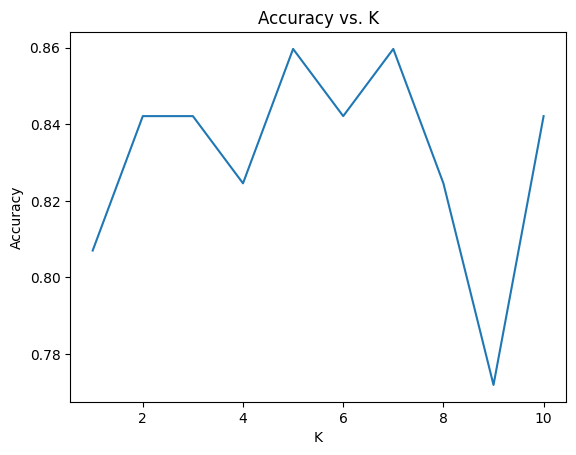

In [92]:
K = np.argmax(accuracies) + 1
print("max accuracy is at K = ",K, "with value = ", accuracies[K-1])

# Assuming accuracies is already populated with accuracy values
K_values = np.arange(1, len(accuracies) + 1)

# Plotting the accuracies against K+1
plt.plot(K_values, accuracies)

# Adding labels and title
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K')

# Displaying the plot
plt.show()

# Displaying the plot
plt.show()




0.8947368421052632


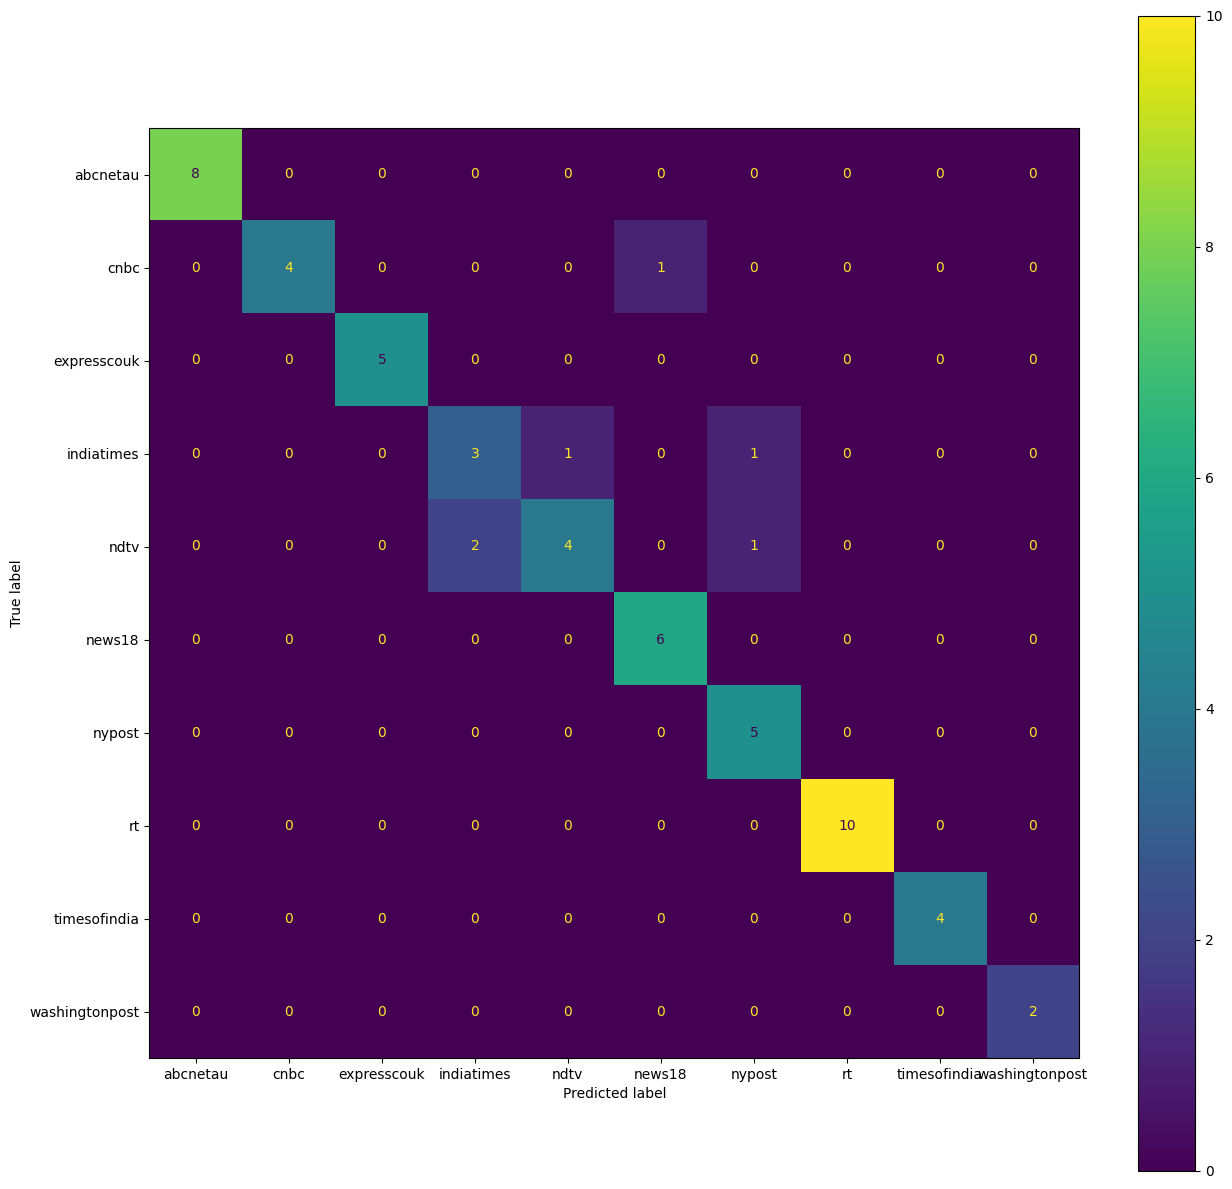

In [93]:
idx = np.random.permutation(len(X))
num_train_obs = np.floor(0.7*len(X))

train_idx = idx[1:int(num_train_obs)]
test_idx = idx[int(num_train_obs):]

# normalization
X_norm = pd.DataFrame()
for key in X:
  temp = X[key]
  temp_norm = (temp-temp.mean())/temp.std();
  X_norm[key] = temp_norm

# split train / test
X_norm_train = X_norm.iloc[train_idx]
X_norm_test = X_norm.iloc[test_idx]

APP_train = APP.iloc[train_idx]
APP_test = APP.iloc[test_idx]

#K-NN classifier: for each entry in the test set, search the closest entry in the train set and assign value!
i = 0;
accuracy = 0
APP_test_predicted = []
for index, row in X_norm_test.iterrows():
  #test_entry = row.values.tolist()
  distances = []
  for ii, rr in X_norm_train.iterrows():
    #train_entry = rr.values.tolist()
    #distances.append(np.linalg.norm(np.array(test_entry)-np.array(train_entry)))
    distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))

  min_idx = np.argmin(distances)

  #sorted_idx = np.argsort(distances)
  #predicted_app = APP_train.iloc[sorted_idx[1:K+1]].mode()

  predicted_app = APP_train.iloc[min_idx]
  APP_test_predicted.append(predicted_app)
  if(APP_test.iloc[i] == predicted_app):
      accuracy = accuracy+1
  i = i+1

print(accuracy/len(APP_test))
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(APP_test_predicted, APP_test, ax=ax);
